In [1]:
import scipy
from imageio import imread
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import cytoolz as cz
import tensorflow as tf
import idx2numpy
import functools
from dataget import data 

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
dataset = data("mnist").get()

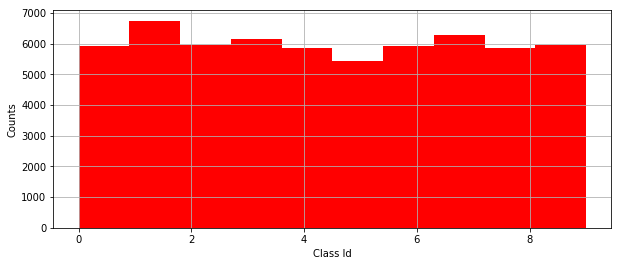

Dataset size:  60000


In [3]:
df = dataset.training_set.dataframe()
df = df.sample(frac=1)

plt.figure(figsize=(10,4))
df.class_id.hist(bins=10, color='r')
plt.xlabel('Class Id')
plt.ylabel('Counts')
plt.show()
print('Dataset size: ', len(df.class_id))

In [4]:
# # for g, f in df.groupby(np.arange(len(df)) // 120):
# #     print(type(f))

# # def get_input_data(dataframe, batch_size, epochs, shuffle):
# #     if epochs is not None:

# def pp(data_set, epochs, steps, batch_size):
    
#     if epochs is not None and epochs >= 1:
#         for _ in range(epochs):
#             for _, f in data_set.groupby(np.arange(len(data_set)) // batch_size):
#                 yield f
                
#     elif epochs is None:
#         for _ in range(steps):
#             data_set = data_set.sample(n=batch_size)
#             image = np.array([i for i in data_set.image])
#             labels = data_set['class_id'].values
#             yield labels.shape

# for j, i in enumerate(pp(df, epochs=2, steps=0, batch_size=5)):
#     if j < 10:
#         print(i.filename.iloc[0])

In [5]:
df.head(5)

,class_id,filename,image
44709,4,/home/ubuntu/.dataget/data/mnist/training-set/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
22189,5,/home/ubuntu/.dataget/data/mnist/training-set/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2686,0,/home/ubuntu/.dataget/data/mnist/training-set/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
55887,2,/home/ubuntu/.dataget/data/mnist/training-set/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
56292,2,/home/ubuntu/.dataget/data/mnist/training-set/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [6]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 100
epochs = 5

# Network Parameters
num_classes = 10 
dropout = 0.25 # Dropout, probability to dnput_fn = tf.estimator.inputs.numpy_inpurop a unit

In [7]:
# Neural Network
def conv_net(features, labels, mode):
    
    print()
    print("#######################")
    print("Model")
    print("#######################")
    
    input_layer = tf.reshape(features["image"], [-1, 28, 28, 1]);print(input_layer)

    conv1 = tf.layers.conv2d(input_layer, 32, 5, activation=tf.nn.relu); print(conv1)
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2); print(pool1)

    conv2 = tf.layers.conv2d(pool1, 64, 5, activation=tf.nn.relu); print(conv2)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2); print(pool2)

    # Flatten the data to a 1-D vector for the fully connected layer
    pool2_flat = tf.contrib.layers.flatten(pool2); print(pool2_flat)

    #fully connected layer
    dense = tf.layers.dense(pool2_flat, 1024, activation=tf.nn.relu); print(dense)

    #dropout
    fc1 = tf.layers.dropout(dense, rate=dropout, training=mode == tf.estimator.ModeKeys.TRAIN); print(fc1)
    logits = tf.layers.dense(fc1, units=num_classes); print(logits)
    print("#######################")
    print()


    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=num_classes)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [8]:
model = tf.estimator.Estimator(model_fn=conv_net, 
        model_dir="/tmp/mnist")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fab8dfe2e80>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
def process(df, epochs=epochs, steps=num_steps, batch_size=batch_size):
    
    if epochs:
        steps = int(len(df)/batch_size)*epochs
        
    for _ in range(steps):
        data_set = df.sample(n=batch_size)
        image = np.array([i for i in data_set.image])
        labels = data_set['class_id'].values
        yield image, labels
          
def input_fn(df):
    dataset = tf.data.Dataset.from_generator(
        functools.partial(process, df=df),
        (tf.float32, tf.float32),
        (tf.TensorShape([batch_size, 28, 28]), tf.TensorShape([batch_size]))
    )
    features, labels = dataset.make_one_shot_iterator().get_next()
    return {'image': features}, labels

In [10]:
# train the model
model.train(input_fn=functools.partial(input_fn, df=df))


#######################
Model
#######################
Tensor("Reshape:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(100, 24, 24, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(100, 12, 12, 32), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(100, 8, 8, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(100, 4, 4, 64), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(100, 1024), dtype=float32)
Tensor("dense/Relu:0", shape=(100, 1024), dtype=float32)
Tensor("dropout/dropout/mul:0", shape=(100, 1024), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(100, 10), dtype=float32)
#######################

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist/model.ckpt.
INFO:tensorflow:loss = 36.1729, step = 1
INFO:tensorflow:global_step/sec: 82.8261
INFO:tensorflow:loss = 0.321721, step = 101 (1.208 sec)
INFO:tensorflow:global_step/sec: 92.4974
INFO:tensorflow:loss = 0.274213, step = 

In [11]:
# Evaluate the Model
model.evaluate(input_fn=functools.partial(input_fn, df=dataset.test_set.dataframe()))


#######################
Model
#######################
Tensor("Reshape:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(100, 24, 24, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(100, 12, 12, 32), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(100, 8, 8, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(100, 4, 4, 64), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(100, 1024), dtype=float32)
Tensor("dense/Relu:0", shape=(100, 1024), dtype=float32)
Tensor("dropout/Identity:0", shape=(100, 1024), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(100, 10), dtype=float32)
#######################

INFO:tensorflow:Starting evaluation at 2018-01-20-04:07:16
INFO:tensorflow:Restoring parameters from /tmp/mnist/model.ckpt-3000
INFO:tensorflow:Finished evaluation at 2018-01-20-04:07:18
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.986, global_step = 3000, loss = 0.0503163


{'accuracy': 0.986, 'global_step': 3000, 'loss': 0.050316252}